In [0]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model

pd.set_option("max_columns",50)

Using TensorFlow backend.


In [0]:
data=pd.read_csv("ita.csv")
print(data.tail(10))

                   data stato  ricoverati_con_sintomi  terapia_intensiva  \
41  2020-04-05T17:00:00   ITA                   28949               3977   
42  2020-04-06T17:00:00   ITA                   28976               3898   
43  2020-04-07T17:00:00   ITA                   28718               3792   
44  2020-04-08T17:00:00   ITA                   28485               3693   
45  2020-04-09T17:00:00   ITA                   28399               3605   
46  2020-04-10T17:00:00   ITA                   28242               3497   
47  2020-04-11T17:00:00   ITA                   28144               3381   
48  2020-04-12T17:00:00   ITA                   27847               3343   
49  2020-04-13T17:00:00   ITA                   28023               3260   
50  2020-04-14T17:00:00   ITA                   28011               3186   

    totale_ospedalizzati  isolamento_domiciliare  totale_positivi  \
41                 32926                   58320            91246   
42                 32874 

In [0]:
print(data.keys())

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'totale_casi', 'tamponi', 'note_it', 'note_en'],
      dtype='object')


In [0]:
a=data['deceduti'][50]

In [0]:
total_rows=data['deceduti'].count()
for i in range(total_rows-1,-1, -1):
    if i==0:
      data['deceduti'][0]=data['deceduti'][0]
    else:
      data['deceduti'][i]=data['deceduti'][i]-data['deceduti'][i-1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
Y=data['deceduti']
print(Y)

0       7
1       3
2       2
3       5
4       4
5       8
6       5
7      18
8      27
9      28
10     41
11     49
12     36
13    133
14     97
15    168
16    196
17    189
18    250
19    175
20    368
21    349
22    345
23    475
24    427
25    627
26    793
27    651
28    601
29    743
30    683
31    662
32    969
33    889
34    756
35    812
36    837
37    727
38    760
39    766
40    681
41    525
42    636
43    604
44    542
45    610
46    570
47    619
48    431
49    566
50    602
Name: deceduti, dtype: int64


In [0]:
X=data.drop(columns=['data','stato','totale_positivi','isolamento_domiciliare','tamponi',
                     'totale_casi','note_it','note_en','dimessi_guariti','deceduti'])
from sklearn.model_selection import train_test_split
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.15 ,shuffle=False)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5,shuffle=False)
print(X)

    ricoverati_con_sintomi  terapia_intensiva  totale_ospedalizzati  \
0                      101                 26                   127   
1                      114                 35                   150   
2                      128                 36                   164   
3                      248                 56                   304   
4                      345                 64                   409   
5                      401                105                   506   
6                      639                140                   779   
7                      742                166                   908   
8                     1034                229                  1263   
9                     1346                295                  1641   
10                    1790                351                  2141   
11                    2394                462                  2856   
12                    2651                567                  3218   
13    

In [0]:
t_model = Sequential()
t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(5,)))
t_model.add(Dropout(0.2))
t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
t_model.add(Dropout(0.1))
t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
t_model.add(Dropout(0.1))
t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
t_model.add(Dropout(0.0))
t_model.add(Dense(1))
t_model.compile(
      loss='mean_squared_error',
      optimizer='nadam',
      metrics=[metrics.mae])

In [0]:
epochs = 100
batch_size = 32

keras_callbacks = [
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

history = t_model.fit(X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(X_val, Y_val),
    callbacks=keras_callbacks)

In [0]:
train_score = t_model.evaluate(X_train, Y_train, verbose=0)
valid_score = t_model.evaluate(X_val, Y_val, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  140.4542 , Train Loss:  34133.5548
Val MAE:  35.0486 , Val Loss:  1990.9341


In [0]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

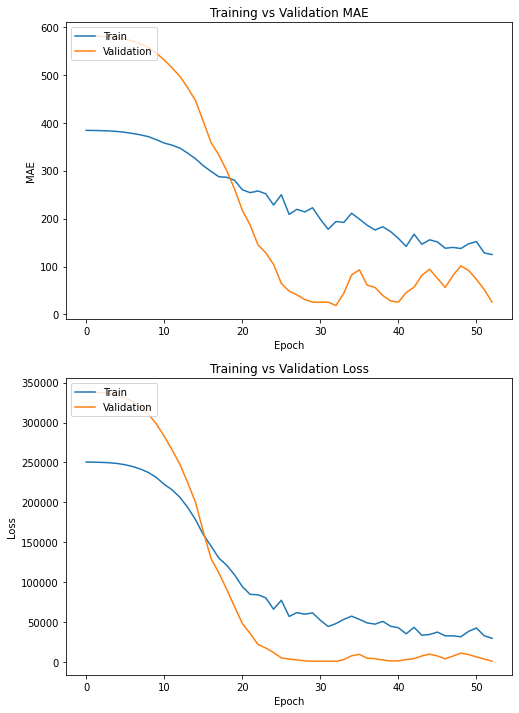

In [0]:
plot_hist(history.history, xsize=8, ysize=12)

In [0]:
t_model.predict(X_test)

array([[655.75415],
       [655.75415],
       [655.75415],
       [655.75415]], dtype=float32)

In [0]:
print(Y_test)

47    619
48    431
49    566
50    602
Name: deceduti, dtype: int64
